In [7]:
import numpy as np
import matplotlib.pylab as plt
from scipy.stats import bernoulli, norm, norminvgauss
np.random.seed(201)

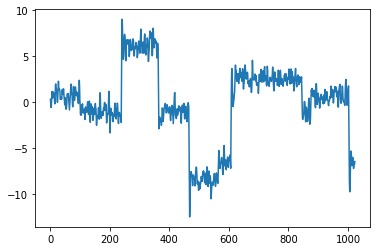

In [8]:
T = 1024

big_shock = 4
med_shock = 2
small_shock = 1

def arma22(N, alpha, beta, rnd, eps=0.5):
    inov = rnd.rvs(2*N)
    x = np.zeros(2*N)

    # arma22 mode
    mean = 0.0
    for i in range(2,N*2):

        rnd = np.random.rand()
        sig = 1 if np.random.rand() > 0.5 else -1
        if(rnd > 0.997):
            mean += sig * big_shock
        elif(rnd > 0.995):
            mean += sig * med_shock
        elif(rnd > 0.990):
            mean += sig * small_shock
        # else do nothing

        x[i] = mean + (alpha[0] * x[i-1] + alpha[1]*x[i-2] + 
                    beta[0] * inov[i-1] + beta[1] * inov[i-2] + eps * inov[i])
    result = x[N:]
    return result - np.mean(result)

alpha = [0.95, -0.5]
beta = [0.4, 0.0]
eps = 0.1

series = arma22(T, alpha, beta, norm(1.0), eps=eps)
plt.plot(series)

In [9]:
from scipy.ndimage import gaussian_filter

#  FIXME make the spacing between scales logarithmic
scales = np.arange(1, T//4, 2)
scale_space = [gaussian_filter(series, i, 2) for i in scales]
saddle = [gaussian_filter(series, i, 3, mode='reflect') for i in scales]

def find_zeros(scal, saddl):
    return np.logical_and(np.sign(scal[1:]) != np.sign(scal[:-1]),
            np.logical_not( np.sign(saddl[1:]) != np.sign(saddl[:-1]) ))

edges = np.vstack([find_zeros(*i) for i in zip(scale_space, saddle)]).T
saddle = np.vstack(saddle).T
scale_space = np.vstack(scale_space).T

(1023.0, 0.0)

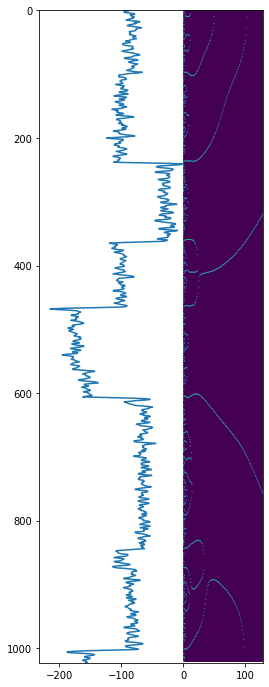

In [10]:
fig, ax = plt.subplots(figsize=(4,12))

ax.imshow(edges, aspect='auto')
ax.plot( 10*(series - np.max(series)), np.arange(len(series)))
ax.set_ylim([T-1,0])

In [11]:
#  Concept (Based on Witkin's paper) for tracking the contours:
#  1. none of the contours should intersect.
#  2. a feature at a larger scale is visible at all smaller scales.
#  Suppose we start at the coarsest scale and find all the zeros, this 
#  will define. Boundary conditions are that there is always an
#  edge at the boundary

# Boundary conditions
edges[0, :] = True
edges[-1, :] = True


In [22]:
contours = list(enumerate(np.where(edges[:,-1])[0].tolist()))
print(contours)
contours = list(enumerate(np.where(edges[:,-26])[0].tolist()))
print(contours)

[(0, 0), (1, 322), (2, 757), (3, 1022)]
[(0, 0), (1, 13), (2, 361), (3, 701), (4, 1022)]


In [25]:
# because there isn't a new contour, and that the contours don't cross, we
# therefore know that the contour labels can just be based on the previous sequence
# 0, 1, 2, 3 in this case
contours = list(enumerate(np.where(edges[:,-25])[0].tolist()))
contours

[(0, 0), (1, 360), (2, 703), (3, 1022)]

In [29]:
# An extra change point appeared! Which one is new?
contours = list(enumerate(np.where(edges[:,-26])[0].tolist()))
contours

[(0, 0), (1, 13), (2, 361), (3, 701), (4, 1022)]

In [42]:
# We've got an extra contour, which of the zeros gets the new label(s)
def test_new(x):
    return not np.any(x)

def window(series, i, j):
    # FIXME should take the bounds between previous/next edge
    return series[max(i-10, 0):min(i+10, T-1), j]

[(i[1], test_new(window(edges, i[1], -25))) for i in contours[1:-1]]
# 1. Because the contours don't cross, we know that the
# one(s) that don't have a change point with the previous scale
# are new. So they get a new label, the other ones get labeled 
# with the previous contour labels.


[(13, True), (361, False), (701, False)]